In [1]:
from scipy.stats import median_abs_deviation

import sys
sys.path.insert(0, '/home/workspace/mm_analysis')
sys.path.insert(0, '/home/workspace/')

from py_util import *
from utilities import *

hdir = '/home/workspace'
wdir = hdir + "/mm_analysis/EXP-01244"
objdir = wdir + "/object_building_processing/objects/"

adata = sc.read_h5ad(objdir + "processed_merged_adata.h5ad")

In [7]:
cr_outs_path = os.path.join(hdir, "mm_analysis/EXP-01244/data/EXP-01244_cr_outs")

# Dictionary mapping user-friendly sample names to their corresponding IDs
sample_dict = {
   'week2': "OR07965-01",    
   'week3': "OR07965-02", 
   'week4': "OR00001",
   'bm': "BMC07965-007",
   'msc': "CELL00911"
}

name_dict = {
   'week2': "Week 2",
   'week3': "Week 3", 
   'week4': "Week 4",
   'bm': "BMMC Start Sample",
   'msc': "MSC Start Sample"   
}

# Create reverse mapping from sample IDs to their user-friendly names
id_to_sample = {v: k for k, v in sample_dict.items()}

# Find all filtered_feature_bc_matrix.h5 files in the directory structure
h5_paths = [os.path.join(root, 'sample_filtered_feature_bc_matrix.h5') 
           for root, _, files in os.walk(cr_outs_path) 
           if 'sample_filtered_feature_bc_matrix.h5' in files]

filtered_adatas = {}

for sample in sample_dict.values():

    # Get only the sample h5 paths
    paths = [path for path in h5_paths if sample in path]

    # Dictionary to store AnnData objects for each sample
    adatas = {}
    
    # Process each H5 file
    for path in paths:
        # Extract sample name from path
        name = path.split('per_sample_outs/')[1].split('/')[0]
        
        # Read the H5 file and create AnnData object
        adata = sc.read_10x_h5(path)
        adata.var_names_make_unique()
    
        adata.obs['sample'] = name
    
        adata.obs['base_sample'] = adata.obs['sample'].str.replace(r'_\d+$', '', regex=True)      # Add metadata column for batched replicates
        adata.obs['sample_type'] = adata.obs['base_sample'].replace(id_to_sample)                 # Add sample names (week2, week3, etc.)
        adata.obs['name'] = adata.obs['sample_type'].replace(name_dict)                           # Add pretty names (Week 2, Week 3, etc.)
    
        adatas[name] = adata.copy()
    
    adata = ad.concat(adatas.values(), join='outer', merge='same')
    
    adata.var["mt"] = adata.var_names.str.startswith("MT-")                 # mitochondrial genes
    adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))      # ribosomal genes
    adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))           # hemoglobin genes
    
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True)
    
    adata.obs["mt_outlier"] = adata.obs['pct_counts_mt'] >= 10

    # Run Scrublet for doublet detection
    scrub = scrublet.Scrublet(adata.X)
    doublet_scores, predicted_doublets = scrub.scrub_doublets(verbose=False)
    
    # Add Scrublet results to cell metadata
    adata.obs['doublet_score'] = doublet_scores
    adata.obs['predicted_doublet'] = predicted_doublets

    # Filtering outliers
    adata = adata[(adata.obs["predicted_doublet"] == False) & (adata.obs["mt_outlier"] == False)].copy()

    filtered_adatas[adata.obs['sample_type'].unique()[0]] = adata.copy()

adata = ad.concat(filtered_adatas.values(), join='outer', merge='same')

# Store log1p transformed normalized counts
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

# Saving raw adata
adata.raw = adata

# Standard processing workflow
sc.pp.highly_variable_genes(adata)
sc.pp.scale(adata)
sc.pp.pca(adata)

# Harmonizing data based on sample type
X = adata.obsm['X_pca'].astype(np.float64)
harmony_out = hm.run_harmony(X, adata.obs, 'sample_type')
adata.obsm['X_pca'] = harmony_out.Z_corr.T

sc.pp.neighbors(adata)
sc.tl.umap(adata)

# Computing a range of leiden resolutions from 0-2 in increments of 0.1
res_range = np.round(np.arange(0, 2.2, 0.1), 1)
for res in res_range:
    sc.tl.leiden(
        adata,
        flavor="igraph",
        key_added=f"leiden_{str(res).replace('.', '_')}",
        n_iterations=2,
        resolution=res
    )

adata.uns['leiden_ranges'] = [f'leiden_{i:.1f}'.replace('.', '_') for i in np.arange(0, 2.1, 0.1)]

sc.tl.paga(adata, groups='leiden_0_9')
sc.tl.rank_genes_groups(adata, 'leiden_0_9', method='t-test', key_added="t-test")

adata.write(objdir + 'processed_merged_adata.h5ad', compression='gzip')

2025-02-17 18:13:01,410 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Computing initial centroids with sklearn.KMeans...
2025-02-17 18:13:06,279 - harmonypy - INFO - sklearn.KMeans initialization complete.
sklearn.KMeans initialization complete.
2025-02-17 18:13:06,463 - harmonypy - INFO - Iteration 1 of 10
Iteration 1 of 10
2025-02-17 18:13:16,215 - harmonypy - INFO - Iteration 2 of 10
Iteration 2 of 10
2025-02-17 18:13:27,506 - harmonypy - INFO - Converged after 2 iterations
Converged after 2 iterations
... storing 'sample' as categorical
... storing 'base_sample' as categorical
... storing 'sample_type' as categorical
... storing 'name' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
/home/workspace/environment/mm_py_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which ha

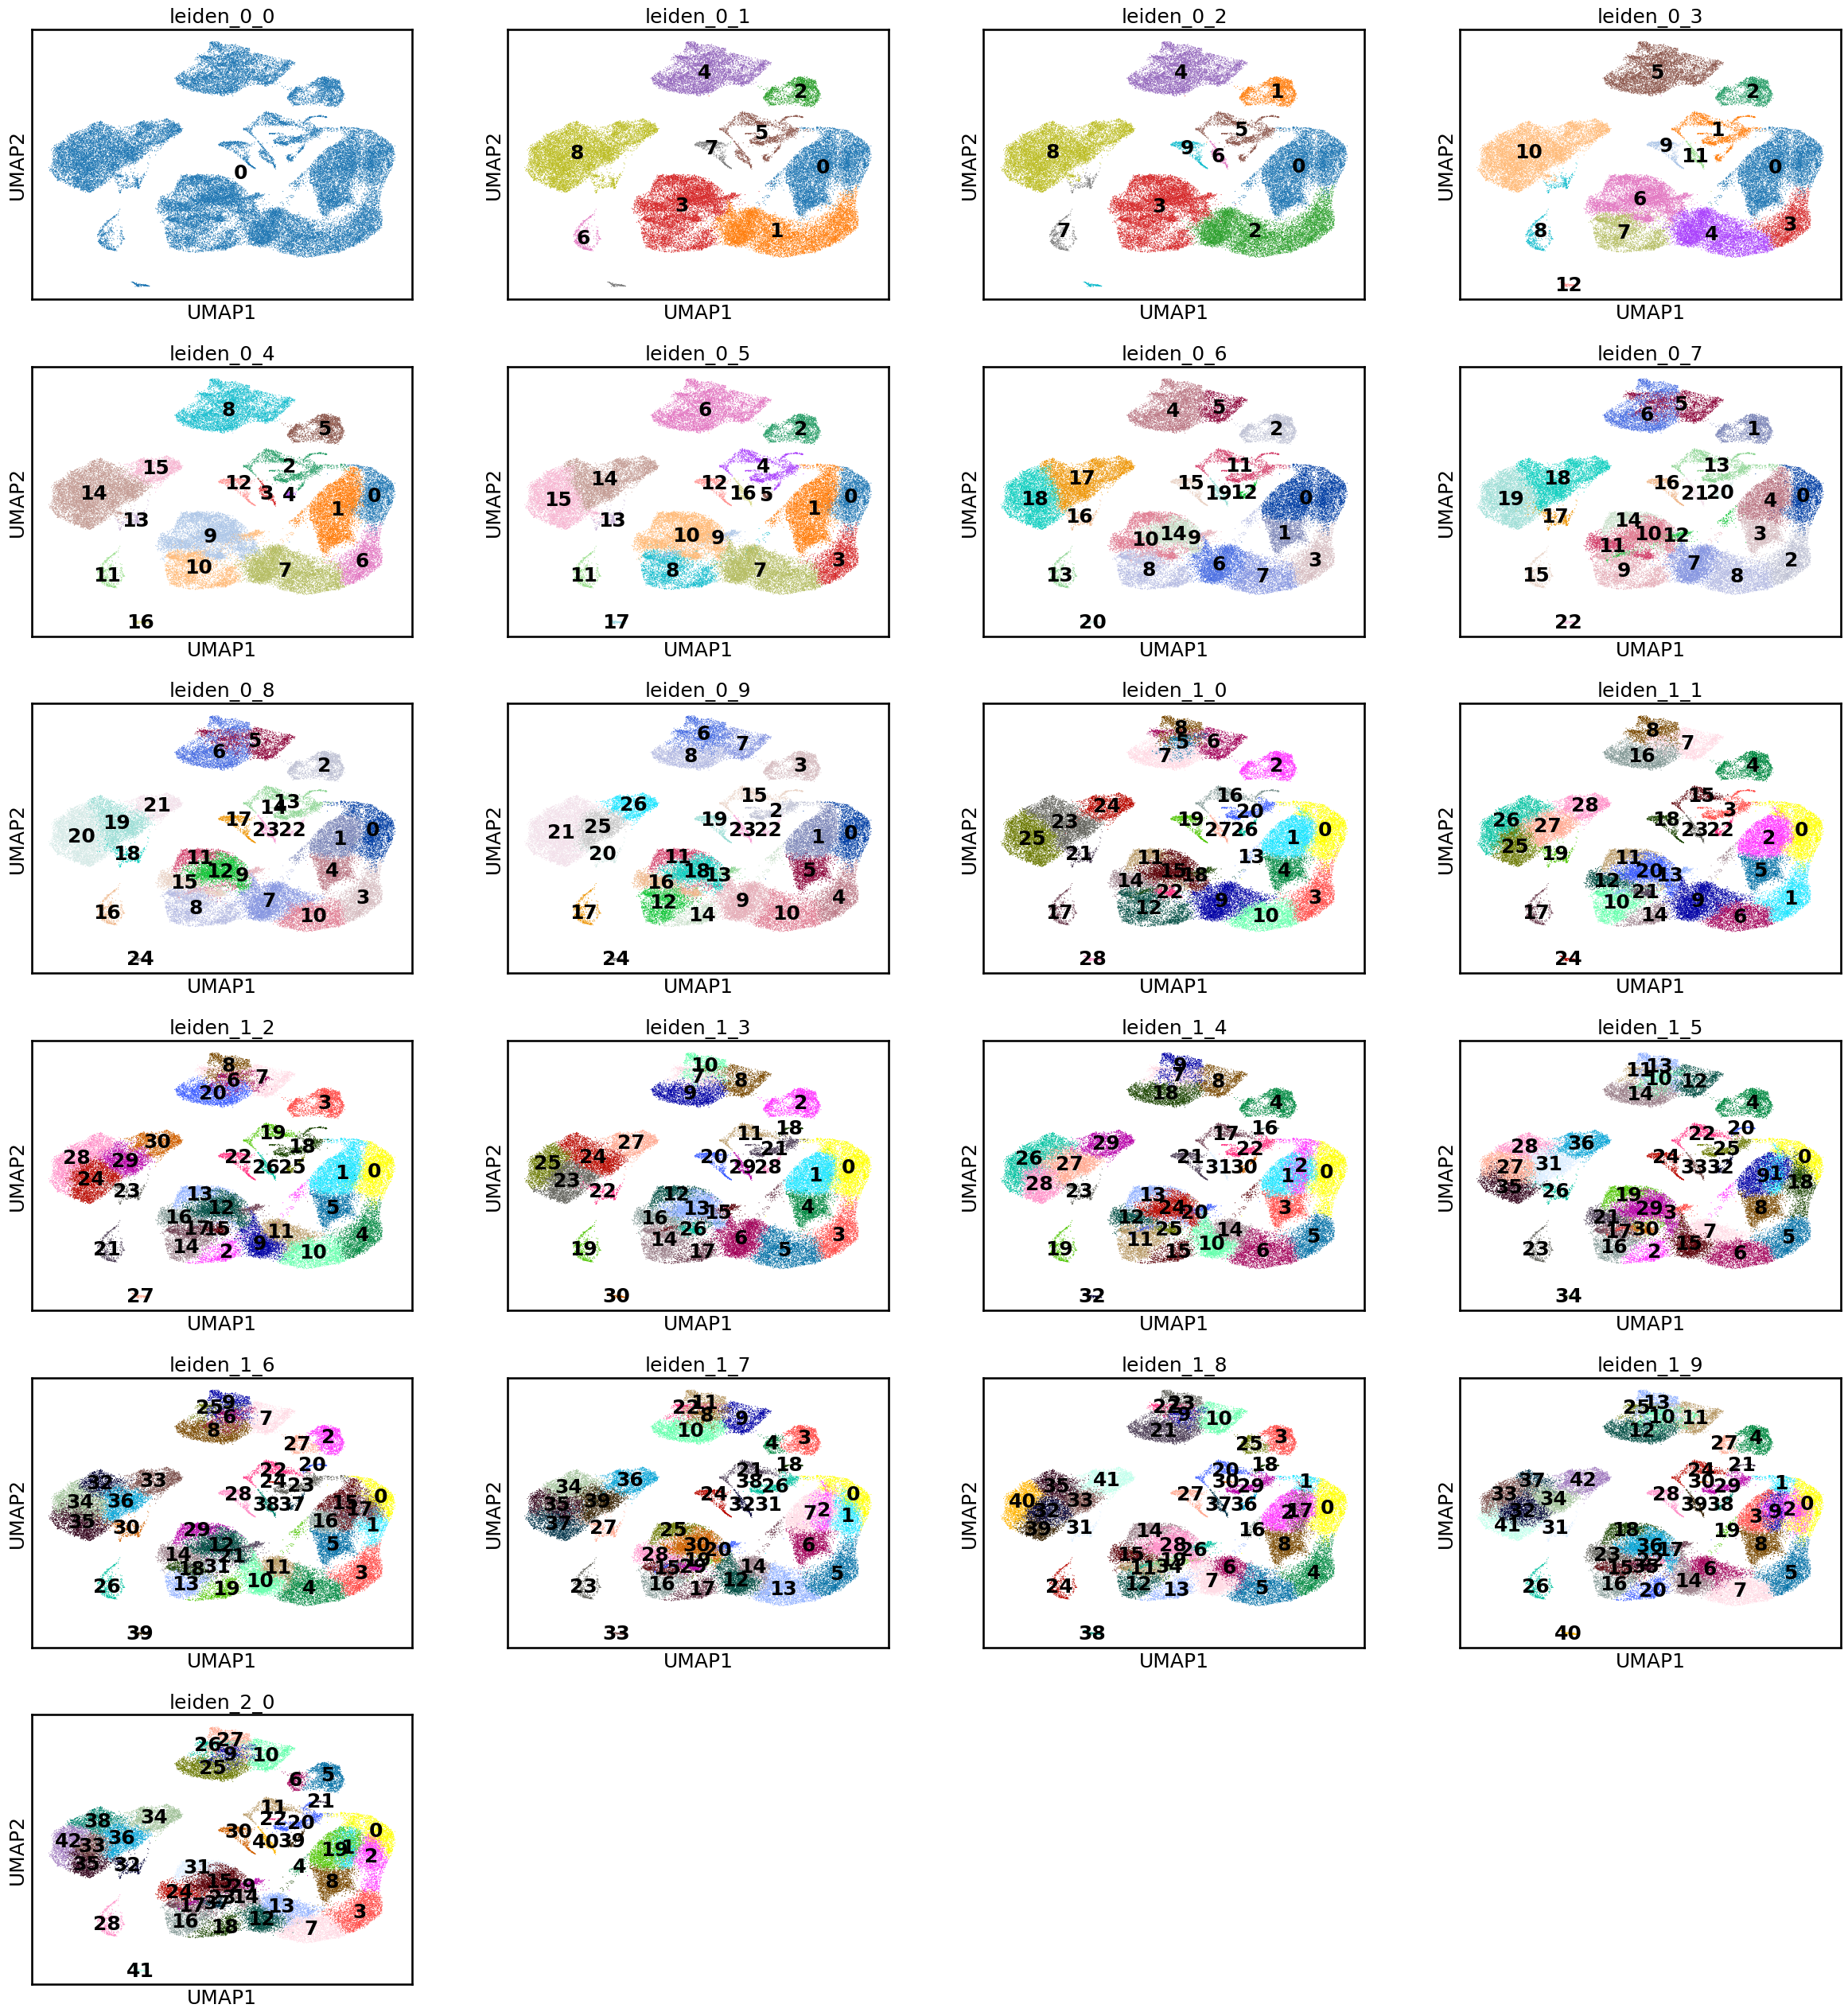

In [4]:
sc.pl.umap(
    adata,
    color=adata.uns['leiden_ranges'],
    legend_loc='on data'
)

In [ ]:
samples = adata.obs['sample_type'].unique()

for tissue_type in sample_types:
    mask = adata.obs['sample_type'] == tissue_type
    ranking = adata[mask].uns['rank_genes_groups']
    gene_names = ranking['names']
    gene_scores = ranking['scores']
    gene_pvals_adj = ranking['pvals_adj']
    clusters = gene_names.dtype.names
    
    de_genes = []
    for cluster in clusters:
        names = gene_names[cluster]
        scores = gene_scores[cluster]
        pvals_adj = gene_pvals_adj[cluster]
        for name, score, pval_adj in zip(names, scores, pvals_adj):
            if pval_adj < 0.05:
                de_genes.append((cluster, name, score, pval_adj))
    
    df_de_genes = pd.DataFrame(de_genes, columns=['Cluster', 'Gene', 'Score', 'Adjusted p-value'])
    df_de_genes.to_csv(degdir + f'{tissue_type}_DEGs.csv', index=False)